In [37]:
import numpy as np
import random

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-12-30 22:47:50,960: Credentials are already in use. The existing account in the session will be replaced.


Defining the folding techniques

In [38]:
def gate_folding (circuit, scaling=1, way='Left'):
    """
    Function that takes a circuit as a input and apply the gate folding, considering the scaling factor
    Args: circuit = circuit to be folded
          scaling = scaling factor (1=do not fold), (3=fold one time the whole circuit)
          way = which way to fill the circuit for s values: Left, Right, Random
    return: the circuit folded
    """
    # properties of the circuit
    n_qubits = circuit.width()
    n_gates = circuit.size()
    qubits = list(np.arange(n_qubits))

    # retrieving from the scaling factor the number of times we need to fold completely each single gate
    ratio = (scaling - 1) / 2
    # number of times we need to fold the whole circuit
    n = int(ratio)
    # number layers to be folded again one more time
    s = int((ratio - n) * n_gates)

    circuit_folded = circuit.copy()

    count = 1
    list_gates = list(np.arange(n_gates))
    random_gates = random.sample(list_gates, s)

    for i in range(n_gates):
        instruction = circuit.data[i]

        # computing the inverse and storing it into another instruction
        instruction_inverse = list(instruction)
        instruction_inverse[0] = instruction[0].inverse()
        instruction_inverse = tuple(instruction_inverse)

        for k in range(n):

            #folding the circuit for n times
            circuit_folded.data.insert(i+count, instruction_inverse)
            count+=1
            circuit_folded.data.insert(i + count, instruction)
            count += 1

        if (way=='Left'):
            if (i < s):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1

        if (way=='Right'):
            if (i >= (n_gates-s)):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1

        if (way=='Random'):
            if (i in random_gates):
                circuit_folded.data.insert(i + count, instruction_inverse)
                count += 1
                circuit_folded.data.insert(i + count, instruction)
                count += 1


    return circuit_folded



In [39]:
def circuit_folding (circuit, scaling=1):
    """
    Function that takes a circuit as a input and apply the circuit folding, considering the scaling factor
    Args: circuit = circuit to be folded
          scaling = scaling factor (1=do not fold), (3=fold one time the whole circuit)
    return: the circuit folded
    """
    #properties of the circuit
    n_qubits = circuit.width()
    qubits = list(np.arange(n_qubits))

    #retrieving from the scaling factor the number of times we need to apply the circuit
    ratio = (scaling-1)/2
    #number of times we need to fold the whole circuit
    n = int(ratio)
    #number of last layers to be folded again
    s = int((ratio-n)*circuit.size())

    circuit_folded = circuit.copy()
    c_inv = circuit_folded.inverse()
    circuit_folded.barrier()

    for i in range(0,n,1):
        circuit_folded.append(c_inv, qargs=qubits)
        circuit_folded.barrier()
        circuit_folded.append(circuit, qargs=qubits)

    #creating a partial circuit, made only of the last s layers
    if (s != 0):
        c_partial = QuantumCircuit(QuantumRegister(n_qubits))
        for j in range(circuit.size() - s, circuit.size(), 1):
            tuple = circuit.data[j][0]
            arg = circuit.data[j][1]
            arg_values=[]
            for k in range(len(arg)):
                arg_values.append(arg[k].index)
            c_partial.append(tuple, qargs=list(arg_values))

        circuit_folded.append(c_partial.decompose().inverse(), qargs=qubits)
        circuit_folded.barrier()
        circuit_folded.append(c_partial.decompose(), qargs=qubits)

    return circuit_folded

Defining an executor function to run the simulations

In [40]:
###########################################
#DEFINING AN EXECUTOR FUNCTION
def executor(circuit, sim, shots=10 ** 5, noise_model= None):
    """
    Executes the input circuit and returns the noisy expectation value <A>.
    Args: circuit = circuit to compute the exp value
          sim = simulator where to act
          shots = number of trials
          noise_model = noise to be used
    return: expectation value
    """
    
    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    #print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = execute(circuit_to_run, backend=sim, shots=shots, noise_model=noise_model, optimization_level=0).result()
    counts = job.get_counts()

    # Compute expectation value of the observable
    exp_value = counts['000'] / shots
    return exp_value

Defining the circuit used for the folding technique, given by a Randomized benchmarking

In [41]:
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements

215


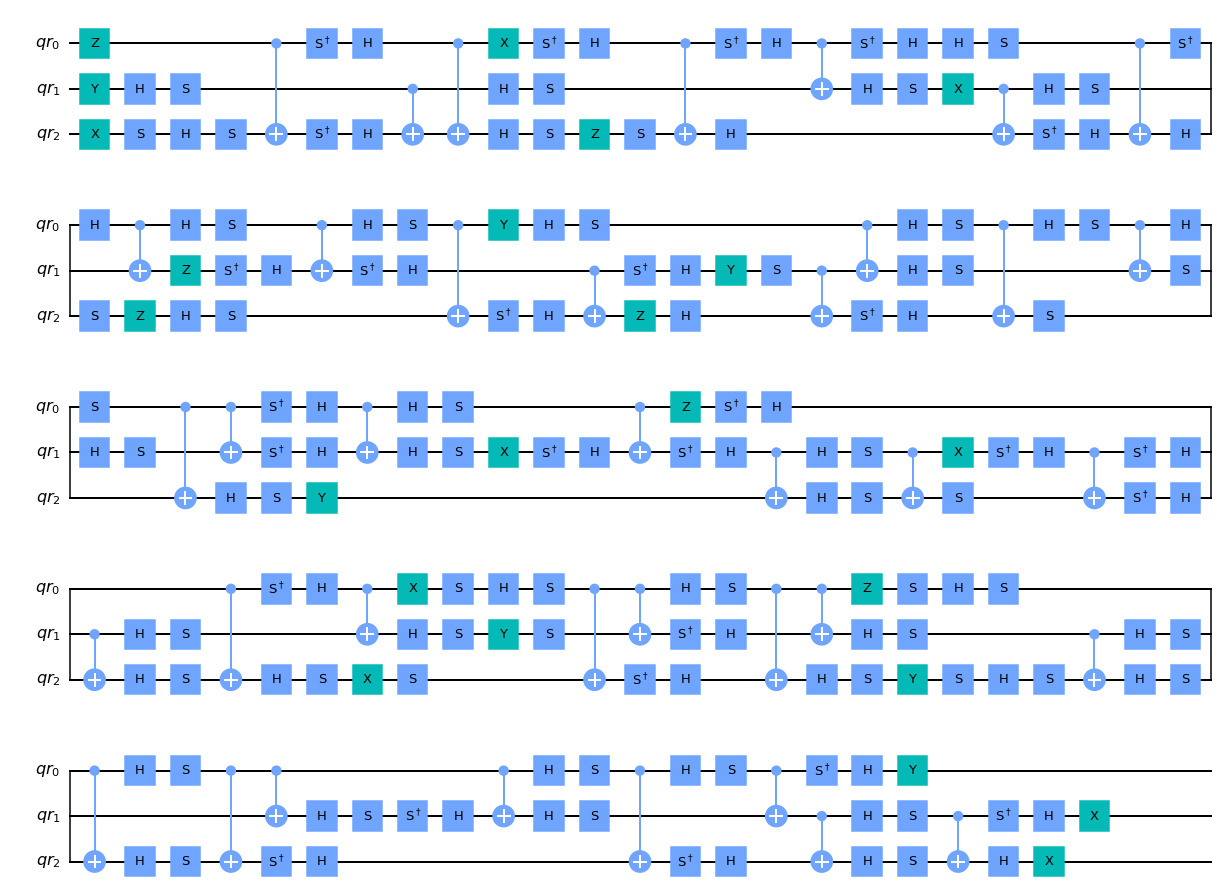

In [42]:
n_qubits = 3
depth = 10

circuit = rb.randomized_benchmarking_seq(
    length_vector=[depth], rb_pattern=[range(n_qubits)], group_gates="0", rand_seed=1,)[0][0][0]

# Remove Barriers
circuit = RemoveBarriers()(circuit)
# Remove Measurements
circuit=RemoveFinalMeasurements()(circuit)

print(circuit.size())
circuit.draw('mpl')

Running the circuit on ideal backend: the result should be 1 as we are using a benchmark

In [43]:
shots = 10 ** 5

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = Aer.get_backend('qasm_simulator')
ideal_value = executor(circuit, ideal_backend, shots)
print('Ideal_value: ', ideal_value)

Ideal_value:  1.0


Executing on noisy backend

In [44]:
backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)

#simulator = QasmSimulator( noise_model=noise_model, enable_truncation = False)

simulator = Aer.get_backend('qasm_simulator', enable_truncation = False)
noisy_value = executor(circuit, simulator, shots, noise_model=noise_model)
print('Noisy_value: ', noisy_value)

Noisy_value:  0.80264


Folding the circuit

In [45]:
print('GATE FOLDING')
circuit_folded_gate = gate_folding(circuit, scaling = 3, way = 'Random')
noisy_value = executor(circuit_folded_gate, simulator, shots, noise_model=noise_model)
print('Noisy_value: ', noisy_value)

#CIRCUIT FOLDING
print('CIRCUIT FOLDING')
circuit_folded_circuit = circuit_folding(circuit, scaling = 3)
noisy_value = executor(circuit_folded_circuit, simulator, shots, noise_model=noise_model)
print('Noisy_value: ', noisy_value)

GATE FOLDING
Noisy_value:  0.56357
CIRCUIT FOLDING
Noisy_value:  0.56191


In [59]:
#definiscilo con la risoluzione che può essere data al tuo sistema in base a d
import pandas as pd
df = pd.DataFrame()
prova=9

scales = np.linspace(1, 6, 21)
i = 0

for scale in scales:
    print(i)
    circuit_folded_gate_left = gate_folding(circuit, scaling=scale, way='Left')
    value_gate_left = executor(circuit_folded_gate_left, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_gate_right = gate_folding(circuit, scaling=scale, way='Right')
    value_gate_right = executor(circuit_folded_gate_right, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_gate_random = gate_folding(circuit, scaling=scale, way='Random')
    value_gate_random = executor(circuit_folded_gate_random, simulator, shots=shots, noise_model=noise_model)

    circuit_folded_circuit = circuit_folding(circuit, scaling=scale)
    value_circuit = executor(circuit_folded_circuit, simulator, shots=shots, noise_model=noise_model)

    new_row = pd.Series(data={"Ideal":ideal_value,"Scale": scale, "Gate Left": value_gate_left, "Gate Right": value_gate_right,
                              "Gate Random": value_gate_random, "Circuit": value_circuit},
                        name='{}'.format(i))
    i += 1

    df = df.append(new_row, ignore_index=False)

df.to_csv('Benchmark_{}.csv'.format(prova))

0
1


/tmp/ipykernel_102/150581611.py:36: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  arg_values.append(arg[k].index)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
